## CAP5610 HW3 - Yuan Du
Code stored at my Github: https://github.com/YuanEldaif/CAP5610


## Task 2 Programming and Evaluation on A Large Dataset (Titanic): 
### Q1: Test your naïve Bayesian classification on the Titanic dataset. Report the average Accuracy, Precision, Recall, and F1 score of your five-fold cross validation. The five-folds of the Titanic data are split randomly. What do you observe and learn by applying Bayesian learning to small datasets and larger datasets? 

In [1]:
#Data analysis and wrangling
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load in the train and test datasets
train = pd.read_csv('C:/Work/Project/CAP5610/HW/HW1/train.csv')
test = pd.read_csv('C:/Work/Project/CAP5610/HW/HW1/test.csv')

combine = [train, test]

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

#Q14 drop ticket
#Q15 drop cabin
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)
combine = [train, test]

#Q16 Convert sex to numeric

for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

#Q17 
# fill missing values with median column values
train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)

#Q18 Fill embarked with mode
freq_port = train.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
#Q19 complete Fare using mode
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)    

# update combine
combine = [train, test]

#Q20 Convert the Fare feature to ordinal values
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
#Convert categorical variables into numeric
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

#Drop Name,PassengerId
train = train.drop(['Name','PassengerId'], axis=1)
test = test.drop(['Name','PassengerId'], axis=1)


### Q2: Implement KNN classification from scratch, and evaluate how K impacts the overall accuracy of kNN on the dataset. Plot the accuracies of kNN over k,  and identify the best K. You can read sample code and try to implement by yourself. Below are some sample implementations from Github for your fast references: 

In [3]:
from sklearn.model_selection import train_test_split
X=train.drop(columns=['Survived','SibSp','Parch','Embarked']).values
y=train['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 4), (712,), (179, 4), (179,))

In [4]:
#Implement KNN from scratch
#Step1 Distance
def get_euclidean_distance(A_matrix, B_matrix):
    
    A_square = np.reshape(np.sum(A_matrix * A_matrix, axis=1), (A_matrix.shape[0], 1))
    B_square = np.reshape(np.sum(B_matrix * B_matrix, axis=1), (1, B_matrix.shape[0]))
    AB = A_matrix @ B_matrix.T

    C = -2 * AB + B_square + A_square

    return np.sqrt(C)

In [5]:
#Step2 Sort neigbors
def get_sorted_train_labels(distance_matrix, y):
    
    order = distance_matrix.argsort(kind='mergesort')

    return np.squeeze(y[order])

In [6]:
#STep3 Count possibilities of each class for k nearest neighbours
def get_p_y_x_using_knn(y, k):
    """
    The function determines the probability distribution p (y | x)
    for each of the labels for objects from the X
    using the KNN classification learned on the X_train

    Args:
        y (numpy.ndarray): Sorted matrix of N2 nearest neighbours labels, size N1:N2
        k (int): number of nearest neighbours for KNN algorithm

    Returns: numpy.ndarray: Matrix of probabilities for N1 points (from set X) of belonging to each class,
    size N1:C (where C is number of classes)
    """

    first_k_neighbors = y[:, :k]
    
    N1, N2 = y.shape
    classes = np.unique(y)
    number_of_classes = classes.shape[0]

    probabilities_matrix = np.zeros(shape=(N1, number_of_classes))

    for i, row in enumerate(first_k_neighbors):
        for j, value in enumerate(classes):
            probabilities_matrix[i][j] = list(row).count(value) / k

    return probabilities_matrix

In [7]:
#Step4 The class with highest possibilty is Your prediction
def predict(X, X_train, y_train, k, distance_function):
    """
    Function returns predictions for new set X based on labels of points from X_train
    Args:
        X (numpy.ndarray): set of observations (points) that we want to label
        X_train (numpy.ndarray): set of lalabeld bservations (points)
        y_train (numpy.ndarray): labels for X_train
        k (int): number of nearest neighbours for KNN algorithm

    Returns:
        (numpy.ndarray): label predictions for points from set X
    """
    distance_matrix = distance_function(X, X_train)

    sorted_labels = get_sorted_train_labels(distance_matrix=distance_matrix, y=y_train)
    
    p_y_x = get_p_y_x_using_knn(y=sorted_labels, k=k)

    number_of_classes = p_y_x.shape[1]
    reversed_rows = np.fliplr(p_y_x)

    prediction = number_of_classes - (np.argmax(reversed_rows, axis=1) + 1)

    return prediction

In [8]:
#Accuracy
def count_accuracy(prediction, y_true):
   
    N1 = prediction.shape[0]
    
    accuracy = np.sum(prediction == y_true) / N1

    return accuracy

In [9]:
#Find best k
from tqdm import tqdm_notebook
def select_knn_model(X_validation, y_validation, X_train, y_train, k_values, distance_function):
    """
    Function returns k parameter that best fit Xval points
    Args:
        Xval (numpy.ndarray): set of Validation Data, size N1:D
        Xtrain (numpy.ndarray): set of Training Data, size N2:D
        yval (numpy.ndarray): set of labels for Validation data, size N1:1
        ytrain (numpy.ndarray): set of labels for Training Data, size N2:1
        k_values (list): list of int values of k parameter that should be checked

    Returns:
        int: k paprameter that best fit validation set
    """

    accuracies = []

    for k in tqdm_notebook(k_values):
        prediction = predict(X_validation, X_train, y_train, k, distance_function)

        accuracy = count_accuracy(prediction, y_validation)
        accuracies.append(accuracy)

    best_k = k_values[accuracies.index(max(accuracies))]

    return best_k, accuracies

C:\Users\alice\anaconda3\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


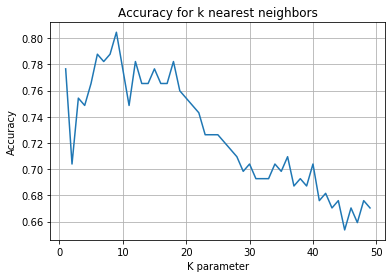

In [10]:
k_values = [i for i in range(1,50)]

best_k, accuracies = select_knn_model(X_test, y_test, X_train, y_train, k_values, distance_function=get_euclidean_distance)

plt.plot(k_values, accuracies)
plt.xlabel('K parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy for k nearest neighbors')
plt.grid()
plt.show()

In [11]:
print("The best K is at K = " ,best_k, "with Maximum accuracy:-",max(accuracies))

The best K is at K =  9 with Maximum accuracy:- 0.8044692737430168
